In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import json, matplotlib
s = json.load(open("styles/bmh_matplotlibrc.json"))
matplotlib.rcParams.update(s)
%matplotlib inline

/Users/Tong/Envs/ds/lib/python3.5/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### load data

In [2]:
loc_data = pd.read_csv('location_data_hw9.csv')
loc_data.head()

,t,red_pos_X,red_pos_Y,blue_pos_X,blue_pos_Y
0,1.471495,1.319862,1.020535,1.156609,-1.320279
1,3.474547,1.287172,1.035155,1.148328,-1.279096
2,6.499981,1.281325,0.983152,1.063136,-1.307599
3,8.514691,1.302247,0.977130,1.122684,-1.284657
4,12.614129,1.299199,0.974123,1.054871,-1.167385


### Visualize data

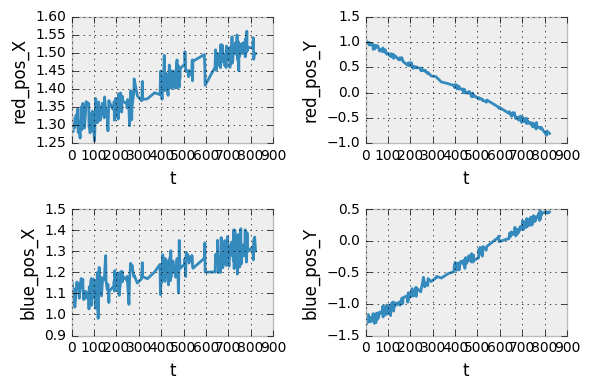

In [3]:
fig, axes = plt.subplots(2,2, figsize=[6, 4])
ylabels = [['red_pos_X', 'red_pos_Y'], ['blue_pos_X', 'blue_pos_Y']]
for i in range(2):
    for j in range(2):
        axes[i,j].plot(loc_data['t'], loc_data[ylabels[i][j]])
        axes[i,j].set_xlabel('t')
        axes[i,j].set_ylabel(ylabels[i][j])
plt.tight_layout()

value of slope and intercept from linear regression

In [4]:
from scipy import stats

slopes, intercepts = {}, {}
columns = ['red_pos_X', 'red_pos_Y', 'blue_pos_X', 'blue_pos_Y']
for var in columns:
    a, b, _, _, _ = stats.linregress(loc_data['t'], loc_data[var])
    slopes[var] = a
    intercepts[var] = b
print(slopes)
print(intercepts)

{'red_pos_Y': -0.0021879757374662942, 'red_pos_X': 0.00028137567569374233, 'blue_pos_Y': 0.0021799257799895548, 'blue_pos_X': 0.00027600907572887339}
{'red_pos_Y': 0.99911053377435977, 'red_pos_X': 1.2980867082224998, 'blue_pos_Y': -1.2961464991468694, 'blue_pos_X': 1.0978055575767751}


## model
We model each coordinates, e.g., $x$, as 
$$x = v_x \times t + x_0 + \epsilon$$

We choose continuous uniform random priors for a, b:
$$v_x\sim Uniform(\text{some range})$$
and $$x_0 \sim Uniform(\text{some range})$$
We use the slopes and intercepts from the linear regressions to determine the ranges.

We choose normal random prior with zero mean for $\epsilon$:
$$ \epsilon\sim Normal(0, \sigma)$$
where $\sigma \sim Uniform(0, \text{some value})$

In [5]:
import pymc3 as pm
import theano.tensor as tt

# a)
## Red / B

In [6]:
with pm.Model() as model_red:
    t = loc_data['t']
    
    xname, yname = 'red_pos_X', 'red_pos_Y'
    obs_x, obs_y = loc_data[xname], loc_data[yname]
    
    # vx --> a, x0 --> b    
    # we choose the range of vx and x0 to be around the values obtained from linear regression
    vx = pm.Uniform('vx', slopes[xname]/5, slopes[xname]*5)
    x0 = pm.Uniform('x0', intercepts[xname]-1, intercepts[xname]+1)
    
    # vy --> a, y0 --> b
    # note that vy is negative
    vy = pm.Uniform('vy', slopes[yname]*5, slopes[yname]/5)
    y0 = pm.Uniform('y0', intercepts[yname]-1, intercepts[yname]+1)    
    
    # speed
    v = pm.Deterministic('v', tt.sqrt(vx**2 + vy**2))
    
    sigma_x = pm.Uniform('sigma_x', 0, 1)
    sigma_y = pm.Uniform('sigma_y', 0, 1)
    
    mu_x = pm.Deterministic('mu_x', vx*t+x0)
    mu_y = pm.Deterministic('mu_y', vy*t+y0)    

Applied interval-transform to vx and added transformed vx_interval_ to model.
Applied interval-transform to x0 and added transformed x0_interval_ to model.
Applied interval-transform to vy and added transformed vy_interval_ to model.
Applied interval-transform to y0 and added transformed y0_interval_ to model.
Applied interval-transform to sigma_x and added transformed sigma_x_interval_ to model.
Applied interval-transform to sigma_y and added transformed sigma_y_interval_ to model.


In [7]:
with model_red:
    mc_x = pm.Normal("mc_x", mu_x, sigma_x, observed=obs_x)
    mc_y = pm.Normal("mc_y", mu_y, sigma_y, observed=obs_y)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(100000, step=step, start=start)
    red_burned_trace = trace[50000::5]

100%|██████████| 100000/100000 [00:54<00:00, 1822.32it/s]


###  posterior of red speed

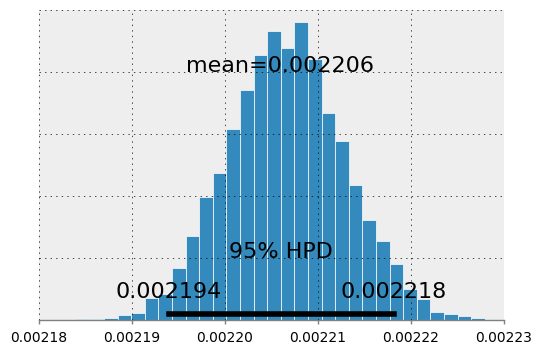

In [33]:
pm.plots.plot_posterior(trace=red_burned_trace["v"], round_to=6, alpha_level=0.05)

## Blue / A

In [9]:
with pm.Model() as model_blue:
    t = loc_data['t']
    
    xname, yname = 'blue_pos_X', 'blue_pos_Y'
    obs_x, obs_y = loc_data[xname], loc_data[yname]
    
    # vx --> a, x0 --> b    
    vx = pm.Uniform('vx', slopes[xname]/5, slopes[xname]*5)
    x0 = pm.Uniform('x0', intercepts[xname]-1, intercepts[xname]+1)
    
    # vy --> a, y0 --> b
    # note that vy is negative 
    # we choose the range of vx and x0 to be around the values obtained from linear regression    
    vy = pm.Uniform('vy', slopes[yname]/5, slopes[yname]*5)
    y0 = pm.Uniform('y0', intercepts[yname]-1, intercepts[yname]+1)    
    
    # speed
    v = pm.Deterministic('v', tt.sqrt(vx**2 + vy**2))
    
    sigma_x = pm.Uniform('sigma_x', 0, 1)
    sigma_y = pm.Uniform('sigma_y', 0, 1)
    
    mu_x = pm.Deterministic('mu_x', vx*t+x0)
    mu_y = pm.Deterministic('mu_y', vy*t+y0)    

Applied interval-transform to vx and added transformed vx_interval_ to model.
Applied interval-transform to x0 and added transformed x0_interval_ to model.
Applied interval-transform to vy and added transformed vy_interval_ to model.
Applied interval-transform to y0 and added transformed y0_interval_ to model.
Applied interval-transform to sigma_x and added transformed sigma_x_interval_ to model.
Applied interval-transform to sigma_y and added transformed sigma_y_interval_ to model.


In [10]:
with model_blue:
    mc_x = pm.Normal("mc_x", mu_x, sigma_x, observed=obs_x)
    mc_y = pm.Normal("mc_y", mu_y, sigma_y, observed=obs_y)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(100000, step=step, start=start)
    blue_burned_trace = trace[50000::5]

100%|██████████| 100000/100000 [00:50<00:00, 1967.81it/s]


### posterior of blue speed

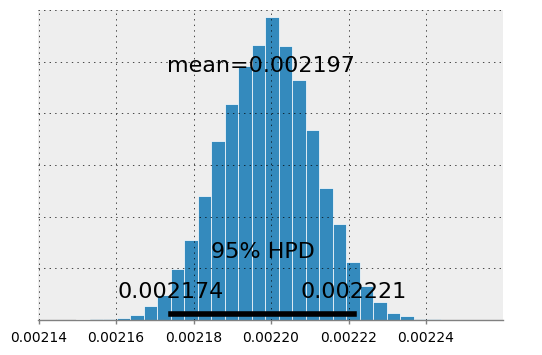

In [32]:
pm.plots.plot_posterior(trace=blue_burned_trace["v"],round_to=6, alpha_level=0.05)

# b)

## model

the transition to $Y_{blue}>0$ and $Y_{red}<0$ happens at $$\tau = max(t_{red}, t_{blue})$$
where $$t_{red} = -y_{0, red}/v_{y,red}$$ and $$t_{blue} = -y_{0, blue}/v_{y,blue}$$

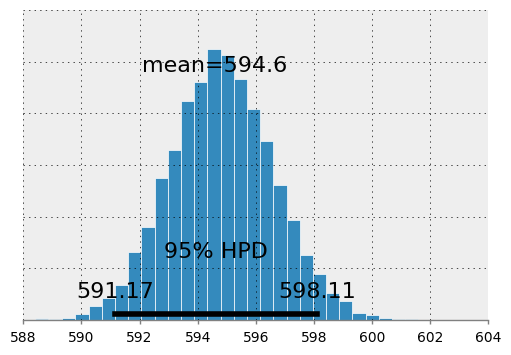

In [37]:
import numpy as np

t_red = -red_burned_trace["y0"]/red_burned_trace["vy"]
t_blue = -blue_burned_trace["y0"]/blue_burned_trace["vy"]
tau = np.max(np.array([t_red, t_blue]), axis=0)
pm.plots.plot_posterior(trace=tau, alpha_level=0.05, round_to=2)

## C)

Now the red and blue points are coupled, so we have to put them under the same model. We choose to have free variables:

 `vx_blue, vy_blue, vx_red`,
 
 `x0_blue, y0_blue, x0_red, y0_red`, 
 
 `sigma_x_red, sigma_y_red, sigma_x_blue, sigma_y_blue`
 
 Notice now, `vy_red` is not an independent random variable now!

In [56]:
with pm.Model() as model_coupled:
    t = loc_data['t']
    
    xname_blue, yname_blue = 'blue_pos_X', 'blue_pos_Y'
    xname_red, yname_red = 'red_pos_X', 'red_pos_Y'
    obs_x_blue, obs_y_blue = loc_data[xname_blue], loc_data[yname_blue]
    obs_x_red, obs_y_red = loc_data[xname_red], loc_data[yname_red]
    
    # vx --> a, x0 --> b    
    vx_blue = pm.Uniform('vx_blue', slopes[xname_blue]/5, slopes[xname_blue]*5)
    x0_blue = pm.Uniform('x0_blue', intercepts[xname_blue]-1, intercepts[xname_blue]+1)
    vx_red = pm.Uniform('vx_red', slopes[xname_red]/5, slopes[xname_red]*5)
    x0_red = pm.Uniform('x0_red', intercepts[xname_red]-1, intercepts[xname_red]+1)
    
    # vy --> a, y0 --> b
    # we choose the range of vx and x0 to be around the values obtained from linear regression    
    vy_blue = pm.Uniform('vy_blue', slopes[yname_blue]/5, slopes[yname_blue]*5)
    y0_blue = pm.Uniform('y0_blue', intercepts[yname_blue]-1, intercepts[yname_red]+1)    
    y0_red = pm.Uniform('y0_red', intercepts[yname_red]-1, intercepts[yname_red]+1)  
    
    # speed
    v = pm.Deterministic('v', tt.sqrt(vx_blue**2 + vy_blue**2))
    
    # vy_red is not independent anymore !!!
    # vy_red is negative
    vy_red = pm.Deterministic('vy_red', -tt.sqrt(v**2 - vx_red**2))

    sigma_x_blue = pm.Uniform('sigma_x_blue', 0, 1)
    sigma_y_blue = pm.Uniform('sigma_y_blue', 0, 1)    
    sigma_x_red = pm.Uniform('sigma_x_red', 0, 1)
    sigma_y_red = pm.Uniform('sigma_y_red', 0, 1)

    
    mu_x_blue = pm.Deterministic('mu_x_blue', vx_blue * t + x0_blue)
    mu_y_blue = pm.Deterministic('mu_y_blue', vy_blue * t + y0_blue)   
    mu_x_red = pm.Deterministic('mu_x_red', vx_red * t + x0_red)
    mu_y_red = pm.Deterministic('mu_y_red', vy_red * t + y0_red)      

Applied interval-transform to vx_blue and added transformed vx_blue_interval_ to model.
Applied interval-transform to x0_blue and added transformed x0_blue_interval_ to model.
Applied interval-transform to vx_red and added transformed vx_red_interval_ to model.
Applied interval-transform to x0_red and added transformed x0_red_interval_ to model.
Applied interval-transform to vy_blue and added transformed vy_blue_interval_ to model.
Applied interval-transform to y0_blue and added transformed y0_blue_interval_ to model.
Applied interval-transform to y0_red and added transformed y0_red_interval_ to model.
Applied interval-transform to sigma_x_blue and added transformed sigma_x_blue_interval_ to model.
Applied interval-transform to sigma_y_blue and added transformed sigma_y_blue_interval_ to model.
Applied interval-transform to sigma_x_red and added transformed sigma_x_red_interval_ to model.
Applied interval-transform to sigma_y_red and added transformed sigma_y_red_interval_ to model.


In [57]:
with model_coupled:
    mc_x_blue = pm.Normal("mc_x_blue", mu_x_blue, sigma_x_blue, observed=obs_x_blue)
    mc_y_blue = pm.Normal("mc_y_blue", mu_y_blue, sigma_y_blue, observed=obs_y_blue)
    mc_x_red = pm.Normal("mc_x_red", mu_x_red, sigma_x_red, observed=obs_x_red)
    mc_y_red = pm.Normal("mc_y_red", mu_y_red, sigma_y_red, observed=obs_y_red)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(100000, step=step, start=start)
    coupled_burned_trace = trace[50000::5]

100%|██████████| 100000/100000 [02:14<00:00, 744.35it/s]


### shared Speed
- The single speed for two objects $(2.204\times 10^{-3})$ lies in between the speeds of each object $(2.206\times 10^{-3}, 2.197\times10^{-3})$

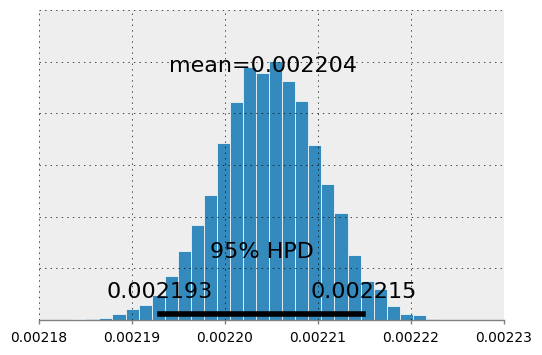

In [58]:
pm.plots.plot_posterior(trace=coupled_burned_trace["v"], round_to=6, alpha_level=0.05)

### Transition time

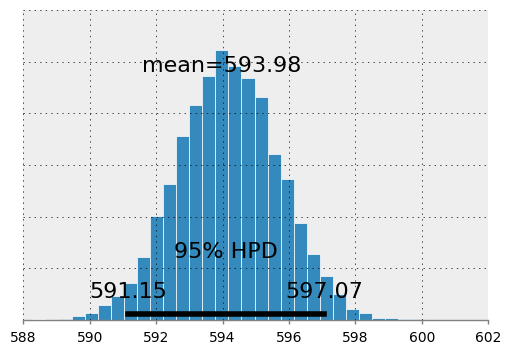

In [59]:
t_red = -coupled_burned_trace["y0_red"]/coupled_burned_trace["vy_red"]
t_blue = -coupled_burned_trace["y0_blue"]/coupled_burned_trace["vy_blue"]
tau = np.max(np.array([t_red, t_blue]), axis=0)
pm.plots.plot_posterior(trace=tau, alpha_level=0.05, round_to=2)

# d)

# Decoupled case with the first 100 data points

In [42]:
# We only use the first 100 data point

N = 100

from scipy import stats

slopes, intercepts = {}, {}
columns = ['red_pos_X', 'red_pos_Y', 'blue_pos_X', 'blue_pos_Y']
for var in columns:
    a, b, _, _, _ = stats.linregress(loc_data['t'][:N], loc_data[var][:N])
    slopes[var] = a
    intercepts[var] = b
print(slopes)
print(intercepts)

{'red_pos_Y': -0.0022305410796566267, 'red_pos_X': 0.00024009074608176816, 'blue_pos_Y': 0.0022885683857230836, 'blue_pos_X': 0.00026658015021622502}
{'red_pos_Y': 1.0043796879697047, 'red_pos_X': 1.3020457237056997, 'blue_pos_Y': -1.3096610546763123, 'blue_pos_X': 1.0996596534500567}


In [43]:
with pm.Model() as model_decoupled_small:
    t = loc_data['t'][:N]
    
    xname_blue, yname_blue = 'blue_pos_X', 'blue_pos_Y'
    xname_red, yname_red = 'red_pos_X', 'red_pos_Y'
    obs_x_blue, obs_y_blue = loc_data[xname_blue][:N], loc_data[yname_blue][:N]
    obs_x_red, obs_y_red = loc_data[xname_red][:N], loc_data[yname_red][:N]
    
    # vx --> a, x0 --> b    
    vx_blue = pm.Uniform('vx_blue', slopes[xname_blue]/5, slopes[xname_blue]*5)
    x0_blue = pm.Uniform('x0_blue', intercepts[xname_blue]-1, intercepts[xname_blue]+1)
    vx_red = pm.Uniform('vx_red', slopes[xname_red]/5, slopes[xname_red]*5)
    x0_red = pm.Uniform('x0_red', intercepts[xname_red]-1, intercepts[xname_red]+1)
    
    # vy --> a, y0 --> b
    # we choose the range of vx and x0 to be around the values obtained from linear regression    
    vy_blue = pm.Uniform('vy_blue', slopes[yname_blue]/5, slopes[yname_blue]*5)
    y0_blue = pm.Uniform('y0_blue', intercepts[yname_blue]-1, intercepts[yname_blue]+1) 
    # notice that vy_red is negative
    vy_red = pm.Uniform('vy_red', slopes[yname_red]*5, slopes[yname_red]/5)    
    y0_red = pm.Uniform('y0_red', intercepts[yname_red]-1, intercepts[yname_red]+1)  
    
    # speed
    v_blue = pm.Deterministic('v_blue', tt.sqrt(vx_blue**2 + vy_blue**2))
    v_red = pm.Deterministic('v_red', tt.sqrt(vx_red**2 + vy_red**2))
    
    sigma_x_blue = pm.Uniform('sigma_x_blue', 0, 1)
    sigma_y_blue = pm.Uniform('sigma_y_blue', 0, 1)    
    sigma_x_red = pm.Uniform('sigma_x_red', 0, 1)
    sigma_y_red = pm.Uniform('sigma_y_red', 0, 1)

    
    mu_x_blue = pm.Deterministic('mu_x_blue', vx_blue * t + x0_blue)
    mu_y_blue = pm.Deterministic('mu_y_blue', vy_blue * t + y0_blue)   
    mu_x_red = pm.Deterministic('mu_x_red', vx_red * t + x0_red)
    mu_y_red = pm.Deterministic('mu_y_red', vy_red * t + y0_red)

Applied interval-transform to vx_blue and added transformed vx_blue_interval_ to model.
Applied interval-transform to x0_blue and added transformed x0_blue_interval_ to model.
Applied interval-transform to vx_red and added transformed vx_red_interval_ to model.
Applied interval-transform to x0_red and added transformed x0_red_interval_ to model.
Applied interval-transform to vy_blue and added transformed vy_blue_interval_ to model.
Applied interval-transform to y0_blue and added transformed y0_blue_interval_ to model.
Applied interval-transform to vy_red and added transformed vy_red_interval_ to model.
Applied interval-transform to y0_red and added transformed y0_red_interval_ to model.
Applied interval-transform to sigma_x_blue and added transformed sigma_x_blue_interval_ to model.
Applied interval-transform to sigma_y_blue and added transformed sigma_y_blue_interval_ to model.
Applied interval-transform to sigma_x_red and added transformed sigma_x_red_interval_ to model.
Applied inte

In [44]:
with model_decoupled_small:
    mc_x_blue = pm.Normal("mc_x_blue", mu_x_blue, sigma_x_blue, observed=obs_x_blue)
    mc_y_blue = pm.Normal("mc_y_blue", mu_y_blue, sigma_y_blue, observed=obs_y_blue)
    mc_x_red = pm.Normal("mc_x_red", mu_x_red, sigma_x_red, observed=obs_x_red)
    mc_y_red = pm.Normal("mc_y_red", mu_y_red, sigma_y_red, observed=obs_y_red)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(100000, step=step, start=start)
    decoupled_small_burned_trace = trace[50000::5]

100%|██████████| 100000/100000 [01:55<00:00, 866.91it/s]


### blue speed

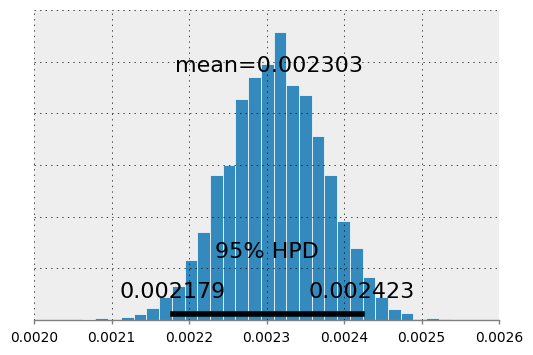

In [46]:
pm.plots.plot_posterior(trace=decoupled_small_burned_trace["v_blue"], round_to=6, alpha_level=0.05)

### red speed

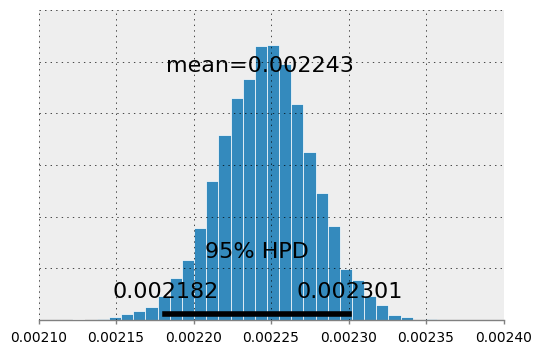

In [48]:
pm.plots.plot_posterior(trace=decoupled_small_burned_trace["v_red"], round_to=6, alpha_level=0.05)

### transition time

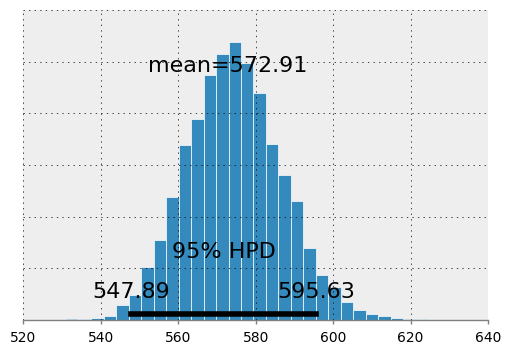

In [49]:
t_red = -decoupled_small_burned_trace["y0_red"]/decoupled_small_burned_trace["vy_red"]
t_blue = -decoupled_small_burned_trace["y0_blue"]/decoupled_small_burned_trace["vy_blue"]
tau = np.max(np.array([t_red, t_blue]), axis=0)
pm.plots.plot_posterior(trace=tau, alpha_level=0.05, round_to=2)

# coupled case with first 100 data points

In [51]:
with pm.Model() as model_coupled_small:
    t = loc_data['t'][:N]
    
    xname_blue, yname_blue = 'blue_pos_X', 'blue_pos_Y'
    xname_red, yname_red = 'red_pos_X', 'red_pos_Y'
    obs_x_blue, obs_y_blue = loc_data[xname_blue][:N], loc_data[yname_blue][:N]
    obs_x_red, obs_y_red = loc_data[xname_red][:N], loc_data[yname_red][:N]
    
    # vx --> a, x0 --> b    
    vx_blue = pm.Uniform('vx_blue', slopes[xname_blue]/5, slopes[xname_blue]*5)
    x0_blue = pm.Uniform('x0_blue', intercepts[xname_blue]-1, intercepts[xname_blue]+1)
    vx_red = pm.Uniform('vx_red', slopes[xname_red]/5, slopes[xname_red]*5)
    x0_red = pm.Uniform('x0_red', intercepts[xname_red]-1, intercepts[xname_red]+1)
    
    # vy --> a, y0 --> b
    # we choose the range of vx and x0 to be around the values obtained from linear regression    
    vy_blue = pm.Uniform('vy_blue', slopes[yname_blue]/5, slopes[yname_blue]*5)
    y0_blue = pm.Uniform('y0_blue', intercepts[yname_blue]-1, intercepts[yname_red]+1)    
    y0_red = pm.Uniform('y0_red', intercepts[yname_red]-1, intercepts[yname_red]+1)  
    
    # speed
    v = pm.Deterministic('v', tt.sqrt(vx_blue**2 + vy_blue**2))
    
    # vy_red is not independent anymore !!!
    # vy_red is negative
    vy_red = pm.Deterministic('vy_red', -tt.sqrt(v**2 - vx_red**2))

    sigma_x_blue = pm.Uniform('sigma_x_blue', 0, 1)
    sigma_y_blue = pm.Uniform('sigma_y_blue', 0, 1)    
    sigma_x_red = pm.Uniform('sigma_x_red', 0, 1)
    sigma_y_red = pm.Uniform('sigma_y_red', 0, 1)

    
    mu_x_blue = pm.Deterministic('mu_x_blue', vx_blue * t + x0_blue)
    mu_y_blue = pm.Deterministic('mu_y_blue', vy_blue * t + y0_blue)   
    mu_x_red = pm.Deterministic('mu_x_red', vx_red * t + x0_red)
    mu_y_red = pm.Deterministic('mu_y_red', vy_red * t + y0_red)      

Applied interval-transform to vx_blue and added transformed vx_blue_interval_ to model.
Applied interval-transform to x0_blue and added transformed x0_blue_interval_ to model.
Applied interval-transform to vx_red and added transformed vx_red_interval_ to model.
Applied interval-transform to x0_red and added transformed x0_red_interval_ to model.
Applied interval-transform to vy_blue and added transformed vy_blue_interval_ to model.
Applied interval-transform to y0_blue and added transformed y0_blue_interval_ to model.
Applied interval-transform to y0_red and added transformed y0_red_interval_ to model.
Applied interval-transform to sigma_x_blue and added transformed sigma_x_blue_interval_ to model.
Applied interval-transform to sigma_y_blue and added transformed sigma_y_blue_interval_ to model.
Applied interval-transform to sigma_x_red and added transformed sigma_x_red_interval_ to model.
Applied interval-transform to sigma_y_red and added transformed sigma_y_red_interval_ to model.


In [52]:
with model_coupled_small:
    mc_x_blue = pm.Normal("mc_x_blue", mu_x_blue, sigma_x_blue, observed=obs_x_blue)
    mc_y_blue = pm.Normal("mc_y_blue", mu_y_blue, sigma_y_blue, observed=obs_y_blue)
    mc_x_red = pm.Normal("mc_x_red", mu_x_red, sigma_x_red, observed=obs_x_red)
    mc_y_red = pm.Normal("mc_y_red", mu_y_red, sigma_y_red, observed=obs_y_red)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(100000, step=step, start=start)
    coupled_small_burned_trace = trace[50000::5]

100%|██████████| 100000/100000 [02:26<00:00, 684.51it/s]


### shared speed

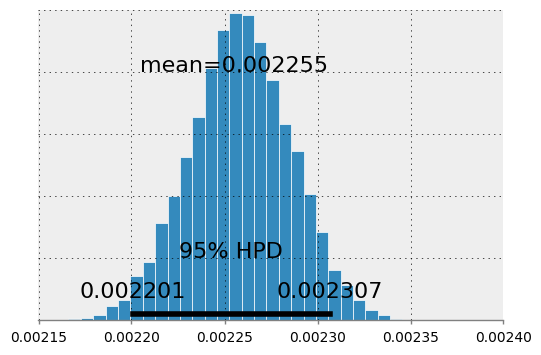

In [54]:
pm.plots.plot_posterior(trace=coupled_small_burned_trace["v"], round_to=6, alpha_level=0.05)

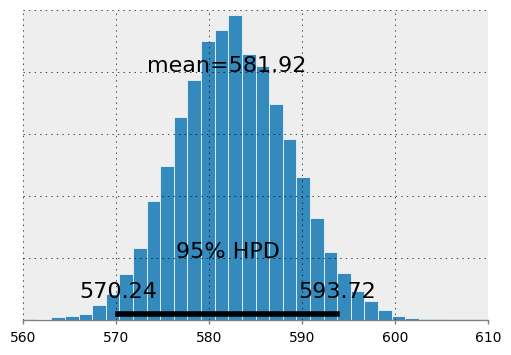

In [55]:
t_red = -coupled_small_burned_trace["y0_red"]/coupled_small_burned_trace["vy_red"]
t_blue = -coupled_small_burned_trace["y0_blue"]/coupled_small_burned_trace["vy_blue"]
tau = np.max(np.array([t_red, t_blue]), axis=0)
pm.plots.plot_posterior(trace=tau, alpha_level=0.05, round_to=2)